# Read Data from the Doppler Lidar

In [1]:
import glob
import utils
import xarray as xr
import pandas as pd
import numpy as np
import cmweather
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from datetime import datetime
from scipy.signal import convolve2d
import scipy
import pyart
import os
import act
import sage_data_client
import cartopy.crs as ccrs
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Compile a list of data files

In [14]:
files = sorted(glob.glob('/Users/rjackson/dl_cal_data/*.hpl'))
#files = ['/Users/rjackson/instrument-cookbooks/notebooks/doppler-lidar/User1_240_20240127_203719.hpl']

In [48]:
def convert_to_hours_minutes_seconds(decimal_hour, initial_time):
    delta = timedelta(hours=decimal_hour)
    return datetime(initial_time.year, initial_time.month, initial_time.day) + delta

def read_as_netcdf(file, lat, lon, alt, transition_threshold_azi=0.01,
                  transition_threshold_el=0.005, round_azi=1, round_el=1):
    field_dict = utils.hpl2dict(file)
    initial_time = pd.to_datetime(field_dict['start_time'])

    time = pd.to_datetime([convert_to_hours_minutes_seconds(x, initial_time) for x in field_dict['decimal_time']])

    ds = xr.Dataset(coords={'range':field_dict['center_of_gates'],
                            'time': time,
                            'azimuth': ('time', np.round(field_dict['azimuth'], round_azi)),
                            'elevation': ('time', np.round(field_dict['elevation'], round_el))} ,
                    data_vars={'radial_velocity':(['time', 'range'],
                                                  field_dict['radial_velocity'].T),
                               'beta': (('time', 'range'), 
                                        field_dict['beta'].T),
                               'intensity': (('time', 'range'),
                                             field_dict['intensity'].T),
                               'spectral_width': (('time', 'range'),
                                             field_dict['spectral_width'].T)
                              }
                   )
    # Fake field for PYDDA
    ds['reflectivity'] = -99 * xr.ones_like(ds['beta'])
    ds['azimuth'] = xr.where(ds['azimuth'] >= 360.0, ds['azimuth'] - 360.0, ds['azimuth'])
    diff_azimuth = ds['azimuth'].diff(dim='time').values
    diff_elevation = np.pad(ds['elevation'].diff(dim='time').values, pad_width=(1, 0))
    unique_elevations = np.unique(ds["elevation"].where(diff_elevation <= transition_threshold_el))
    unique_elevations = unique_elevations[np.isfinite(unique_elevations)]
    counts = np.zeros_like(unique_elevations)
    
    for i in range(len(unique_elevations)):
        counts[i] = np.sum(ds["elevation"].values == unique_elevations[i])
    
    if np.sum(np.abs(diff_azimuth) > transition_threshold_azi) <= 2 and not np.all(ds['elevation'] == 90.0):
        sweep_mode = 'rhi'
        n_sweeps = 1
    elif np.all(ds['elevation'] == 90.0):
        sweep_mode = 'vertical_pointing'
        n_sweeps = 1
    else:
        # We will filter out the transitions between sweeps
        sweep_mode = "azimuth_surveillance"
        n_sweeps = len(unique_elevations)
        
    ds['sweep_mode'] = xr.DataArray(np.array([sweep_mode.lower()], dtype='S32'), dims=['string_length_32'])
    ds['azimuth'] = xr.where(ds['azimuth'] < 360., ds['azimuth'], ds['azimuth'] - 360.)
    
    if sweep_mode == 'rhi':
        ds['fixed_angle'] = ('sweep', 
                             [ds['azimuth'].median().values])
    elif sweep_mode == "azimuth_surveillance" or sweep_mode == "vertical_pointing":
        ds['fixed_angle'] = ('sweep', unique_elevations)
        
    ds['sweep_number'] = ('sweep', np.arange(0, n_sweeps))
    ds['sweep_number'].attrs["long_name"] = "sweep_index_number_0_based"
    ds['sweep_number'].attrs["units"] = ""
    ds['sweep_number'].attrs["_FillValue"] = -9999
    ds["latitude"] = lat
    ds["latitude"].attrs["long_name"] = 'latitude'
    ds["latitude"].attrs["units"] = "degrees_north"
    ds["latitude"].attrs["_FillValue"] = -9999.
    ds["longitude"] = lon
    ds["longitude"].attrs["long_name"] = 'longitude'
    ds["longitude"].attrs["units"] = "degrees_east"
    ds["longitude"].attrs["_FillValue"] = -9999.
    ds["altitude"] = alt
    ds["altitude"].attrs["long_name"] = alt
    ds["altitude"].attrs["units"] = "meters"
    ds["altitude"].attrs["_FillValue"] = -9999.
    num_rays = ds.dims['time']
    diff_elevation = ds["elevation"].diff(dim='time').values
    transitions = np.pad(np.abs(diff_elevation) > transition_threshold_el, (1, 0))
    
    start_indicies = []
    end_indicies = []
    last_ind = 0
    if sweep_mode == "rhi":
        start_indicies = [0]
        end_indicies = [ds.sizes['time']]
    else:
        for i, t in enumerate(unique_elevations):
            where_in_sweep = np.argwhere(ds['elevation'].values == t)
            start_indicies.append(int(where_in_sweep.min()))
            end_indicies.append(int(where_in_sweep.max()))
    end_indicies = np.array(end_indicies)
    
    ds["sweep_start_ray_index"] = ('sweep', start_indicies)
    ds["sweep_start_ray_index"].attrs["long_name"] = "index_of_first_ray_in_sweep"
    ds["sweep_start_ray_index"].attrs["units"] = ""
    ds["sweep_start_ray_index"].attrs["_FillValue"] = -9999
    ds["sweep_end_ray_index"] = ('sweep', end_indicies)
    ds["sweep_end_ray_index"].attrs["long_name"] = "index_of_last_ray_in_sweep"
    ds["sweep_end_ray_index"].attrs["units"] = ""
    ds["sweep_end_ray_index"].attrs["_FillValue"] = -9999
    ds["antenna_transition"] = ('time', transitions)
    ds["antenna_transition"].attrs["long_name"] = "antenna_transition"
    ds["antenna_transition"].attrs["units"] = "1 = transition, 0 = not"
    ds["antenna_transition"].attrs["_FillValue"] = -9999
    ds.attrs["Conventions"] = "CF-1.7"
    ds.attrs["version"] = "CF-Radial-1.4"
    return ds

In [73]:
file = '/Users/rjackson/wfip3/data/User1_190_20250613_190112.hpl'
dataset = read_as_netcdf(file, 41.98053299237866, -87.71662374616044, 0.,
                        transition_threshold_azi=10)

In [68]:
dataset = act.retrievals.compute_winds_from_ppi(dataset)

In [ ]:
dataset["wind_speed"].T.plot()

In [ ]:
dataset.to_netcdf('temp.nc')
radar = pyart.io.read('temp.nc')
radar.info()

(0.0, 4.0)

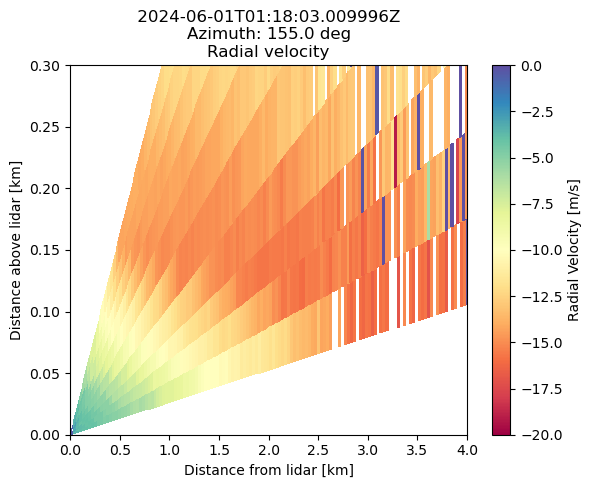

In [45]:
disp = pyart.graph.RadarDisplay(radar)
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_below('intensity', 1.01)
disp.plot_azimuth_to_rhi('radial_velocity', target_azimuth=155,  vmin=-20, vmax=0, cmap='Spectral',
                        filter_transitions=False, gatefilter=gatefilter,
                        colorbar_label='Radial Velocity [m/s]')
plt.ylim([0, 0.3])
plt.ylabel('Distance above lidar [km]')
plt.xlabel('Distance from lidar [km]')
plt.xlim([0, 4])
#plt.gca().invert_yaxis()

In [ ]:
file_list = sorted(glob.glob('/Users/rjackson/wfip3/data/User1_184_20240601_01*.hpl'))
for i, fi in enumerate(file_list):
    try:
        dataset = read_as_netcdf(fi, 41.98053299237866, -87.71662374616044, 0.)
    except ValueError:
        continue
    dataset.to_netcdf('temp.nc')
    radar = pyart.io.read('temp.nc')
    disp = pyart.graph.RadarDisplay(radar)
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_below('intensity', 1.01)
    disp.plot_azimuth_to_rhi('radial_velocity', target_azimuth=155,  vmin=-20, vmax=0, cmap='Spectral',
                            filter_transitions=False, gatefilter=gatefilter,
                            colorbar_label='Radial Velocity [m/s]')
    plt.ylim([0, 1])
    plt.ylabel('Distance above lidar [km]')
    plt.xlabel('Distance from lidar [km]')
    plt.xlim([0, 4])
    plt.savefig('cross_section%d.png' % i, bbox_inches='tight', dpi=150)
    plt.close()

In [63]:
file_list = sorted(glob.glob('/Users/rjackson/wfip3/data/User1_184_20240601_01*.hpl'))
for i, fi in enumerate(file_list):
    try:
        dataset = read_as_netcdf(fi, 41.98053299237866, -87.71662374616044, 0.)
    except ValueError:
        continue
    dataset.to_netcdf('temp.nc')
    radar = pyart.io.read('temp.nc')
    disp = pyart.graph.RadarMapDisplay(radar)
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_below('intensity', 1.01)
    fig, ax = plt.subplots(1, 1)
    disp.plot_ppi('radial_velocity', 3,  vmin=-20, vmax=0, cmap='Spectral',
                            filter_transitions=False, gatefilter=gatefilter,
                            colorbar_label='Radial Velocity [m/s]', ax=ax)
    ax.set_ylim([-4, 0])
    ax.set_ylabel('Lidar northing [km]')
    ax.set_xlabel('Lidar easting [km]')
    #ax.xlabel('Distance from lidar [km]')
    ax.set_xlim([-2, 2])
    fig.savefig('ppi%d.png' % i, bbox_inches='tight', dpi=150)
    plt.close(fig)

In [ ]:
elevations = [2., 3., 4., 5., 7., 9., 11., 13., 15., 17]
dataset_whole = read_as_netcdf(file, 41.98053299237866, -87.71662374616044, 0.)
for i, elevation in enumerate(elevations):
    dataset = dataset_whole.where(dataset_whole["elevation"] == elevation)
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection='polar')
    dataset = dataset.where(dataset['intensity'] > 1.01)
    azi = np.deg2rad(dataset['azimuth'])
    rng = dataset['range']
    x, y = np.meshgrid(azi, rng/1000, indexing='ij')
    c = ax.pcolormesh(x, y, dataset['radial_velocity'], cmap='Spectral', vmin=-20, vmax=0)
    plt.colorbar(c, ax=ax, label='Radial velocity [m/s]', location='bottom')
    ax.set_rlim([0, 3])
    #ax.set_rticks([0, .500, 1.000, 1.500, 2.000], weight='bold')
    ax.set_thetalim([np.deg2rad(255), np.deg2rad(305)])
    ax.set_theta_zero_location("N") 
    ax.set_theta_direction("clockwise") 
    ax.set_ylabel('Range [km]', labelpad=40)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    #fig.tight_layout()
    ax.set_title(dataset['time'].dt.strftime('%Y-%m-%d %H:%M:%S')[0].values + ' %f degrees' % elevation)
    fig.savefig('05deg_scan%d.png' %i, bbox_inches='tight')
    plt.close(fig)

In [17]:
dataset['time'].dt.strftime('%Y-%m-%d %H:%M:%S')[0].values

array('2025-06-13 14:11:09', dtype=object)

In [72]:
dataset["elevation"]

<xarray.DataArray 'elevation' (time: 8)> Size: 64B
array([ 5. ,  5. ,  6.9, 11.2, 14.4, 15. , 15. , 15. ])
Coordinates:
  * time       (time) datetime64[ns] 64B 2025-06-13T19:01:32.360016 ... 2025-...
    azimuth    (time) float64 64B 285.4 285.4 285.4 285.4 ... 285.4 285.4 285.4
    elevation  (time) float64 64B 5.0 5.0 6.9 11.2 14.4 15.0 15.0 15.0

In [ ]:
files = sorted(glob.glob('/Users/rjackson/User5_184_20240819_*.hpl'))
times = []
ds_list = []
for i in range(len(files)):
    dataset = read_as_netcdf(files[i], 41.98053299237866, -87.71662374616044, 0.)
    dataset["signal_to_noise_ratio"] = dataset["intensity"] - 1
    dataset = dataset.where(dataset.range > 90)
    ds_list.append(dataset)
ds = xr.concat(ds_list, dim="time")
print(ds["time"][::6])
tke = 0.5*(ds["radial_velocity"].coarsen(time=6).std().resample(time='1800s').mean())
tke.plot(y="range", vmin=0, vmax=3)
plt.ylim([0, 1500])

In [ ]:
tke

## Generate vads for entire day

/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_80033/916861443.py:73: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_rays = ds.dims['time']


(0.0, 0.1)

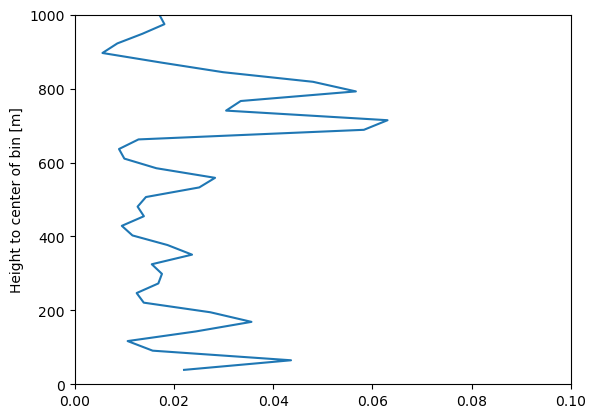

In [23]:
files = glob.glob('/Users/rjackson/wfip3/data/User5_184_20240819_0*.hpl')
times = []
ds_list = []
for i in range(len(files)):
    dataset = read_as_netcdf(files[i], 41.98053299237866, -87.71662374616044, 0.)
    dataset["signal_to_noise_ratio"] = dataset["intensity"] - 1
    times.append(dataset['time'].values[0])
    dataset = act.retrievals.compute_winds_from_ppi(dataset)
    ds_list.append(dataset)

ds = xr.concat(ds_list, dim='time')
ds["u"] = -np.sin(np.deg2rad(ds["wind_direction"])) * ds["wind_speed"]
ds["v"] = -np.cos(np.deg2rad(ds["wind_direction"])) * ds["wind_speed"]
tke = (ds["u"].std(dim="time")**2 + ds["v"].std(dim="time")**2) / 2
tke.T.plot(y='height')
plt.ylim([0, 1000])
plt.xlim([0, 0.1])

In [24]:
ds_vad = xr.concat(ds_list, dim='time')
ds_vad

<xarray.Dataset> Size: 227kB
Dimensions:                (time: 10, height: 400)
Coordinates:
  * time                   (time) datetime64[ns] 80B 2024-08-19T00:00:34.9749...
  * height                 (height) float64 3kB 12.99 38.97 ... 1.038e+04
Data variables:
    wind_speed             (time, height) float64 32kB nan 3.01 ... nan nan
    wind_direction         (time, height) float64 32kB nan 19.27 ... nan nan
    wind_speed_error       (time, height) float64 32kB nan 0.06168 ... nan nan
    wind_direction_error   (time, height) float64 32kB nan 1.174 ... nan nan
    signal_to_noise_ratio  (time, height) float64 32kB -0.1684 ... 0.001337
    residual               (time, height) float64 32kB nan 0.04038 ... nan nan
    correlation            (time, height) float64 32kB nan 0.9992 ... nan nan

/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_80033/916861443.py:73: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_rays = ds.dims['time']


(0.0, 2000.0)

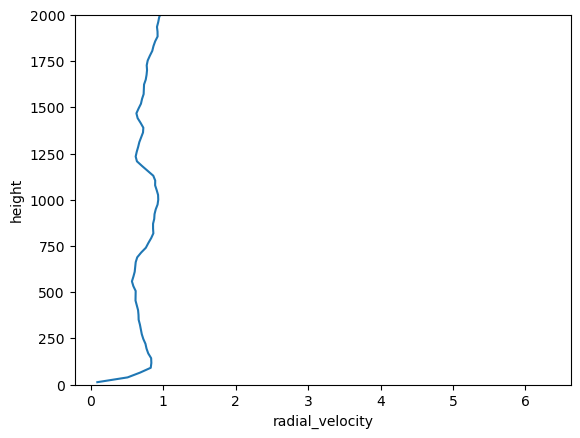

In [22]:
dataset = read_as_netcdf(files[i], 41.98053299237866, -87.71662374616044, 0.)
dataset["height"] = np.sin(np.deg2rad(60)) * dataset["range"]
tke = 0.5* dataset['radial_velocity'].std(dim="time")
tke["height"] = dataset["height"]
tke.plot(y="height")
plt.ylim([0, 2000])

(0.0, 1500.0)

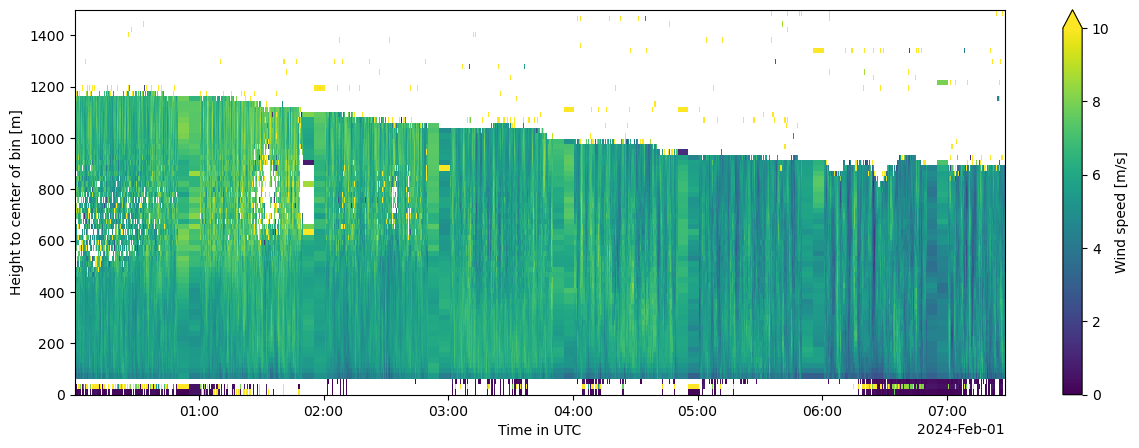

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ds_vad['wind_speed'].T.plot(vmin=0, vmax=10)
plt.ylim([0, 1500])

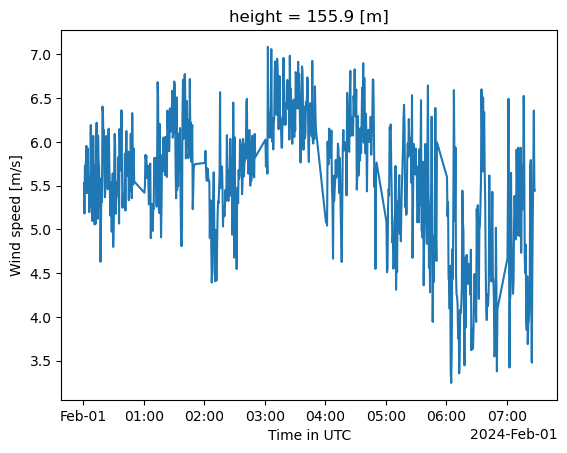

In [19]:
ds_vad['wind_speed'].sel(height=150., method='nearest').plot()

In [234]:
ds = xr.open_mfdataset('/Users/rjackson/wfip3/data/caco.lidar.vad.20240314.nc')

ds["u"] = -np.sin(np.deg2rad(ds["wind_direction"])) * ds["wind_speed"]
ds["v"] = -np.cos(np.deg2rad(ds["wind_direction"])) * ds["wind_speed"]

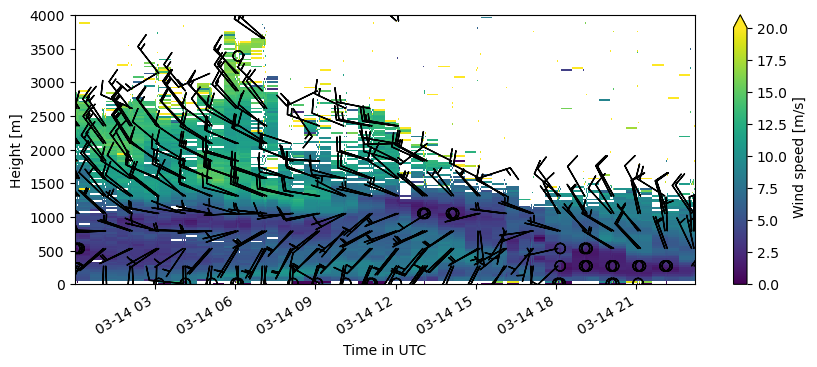

In [235]:
plt.figure(figsize=(10, 3.5))
x, y = np.meshgrid(ds["time"], ds["height"], indexing='ij')
ds["wind_speed"].T.plot(vmin=0, vmax=20)
plt.barbs(x[::10, ::10], y[::10, ::10], ds["u"][::10, ::10], ds["v"][::10, ::10])
plt.ylim([0, 4000])
plt.ylabel('Height [m]')
plt.savefig('vads_March14.png', bbox_inches='tight')

In [236]:
ds = xr.open_mfdataset('/Users/rjackson/wfip3/data/caco.lidar.vad.202403*.nc')
ds = xr.concat([ds, xr.open_mfdataset('/Users/rjackson/wfip3/data/caco.lidar.vad.2024022*.nc')], dim='time')

In [237]:
ds["u"] = -np.sin(np.deg2rad(ds["wind_direction"])) * ds["wind_speed"]
ds["v"] = -np.cos(np.deg2rad(ds["wind_direction"])) * ds["wind_speed"]

In [238]:
u_250m = ds["u"].sel(height=250., method='nearest').values
v_250m = ds["v"].sel(height=250., method='nearest').values

Text(0, 0.5, 'Inertia')

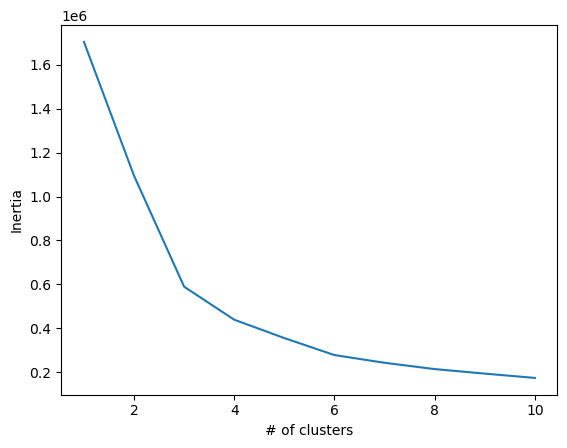

In [239]:
rmse = np.zeros(10)
inds = np.logical_and(np.isfinite(u_250m), np.isfinite(v_250m))
inp_wind = np.stack([u_250m[inds], v_250m[inds]], axis=-1)
for n_clusters in range(1, 11):
    km = KMeans(n_clusters=n_clusters, n_init=10)
    km.fit(inp_wind)
    rmse[n_clusters - 1] = km.inertia_
plt.plot(np.arange(1, 11, 1), rmse)
plt.xlabel('# of clusters')
plt.ylabel('Inertia')

In [241]:
km = KMeans(n_clusters=3, n_init=10)
inp_wind = np.stack([u_250m[inds], v_250m[inds]], axis=-1)
km.fit(inp_wind)
inp_wind = np.stack([u_250m, v_250m], axis=-1)
inp_wind = np.nan_to_num(inp_wind)
ds["cluster"] = ("time", km.predict(inp_wind))
ds["cluster"] = ds["cluster"].where(inds)

TypeError: The DType <class 'numpy.dtype[float64]'> could not be promoted by <class 'numpy.dtype[datetime64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[datetime64]'>)

/Users/rjackson/ACT/act/plotting/plot.py:81: UserWarning: Could not discern datastreamname and dict or tuple were not provided. Using defaultname of act_datastream!
  warnings.warn(


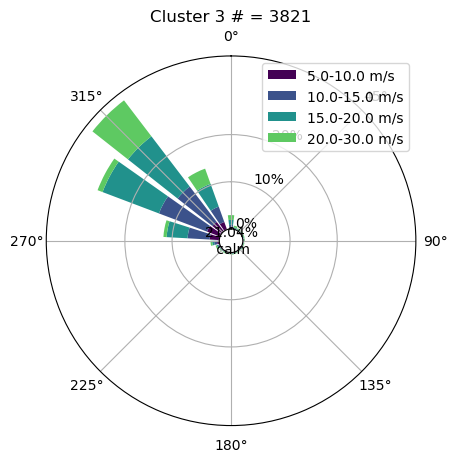

In [251]:
cluster = 2
disp = act.plotting.WindRoseDisplay(ds.where(ds.cluster == cluster))
disp.plot("wind_direction", "wind_speed", tick_interval=10, spd_bins=[5, 10, 15, 20, 30])
plt.title('Cluster %d' % (cluster + 1) + " # = %d" % np.sum(ds.cluster == cluster))
plt.savefig('wind_cluster%d.png' % (cluster+1), bbox_inches='tight')

In [102]:
# Get a JSON blob of URLs of image files stored by the wfip2/lidar.z09.00 Dataset in a 48 hour period
import json
import base64
import requests

api_url = 'https://70d76sxu18.execute-api.us-west-2.amazonaws.com/prod'

# Prepare auth header
auth = {
    "Authorization": "Basic {}".format(base64.b64encode(
	("{}:{}".format("guest", "guest")).encode("utf-8")
    ).decode("ascii"))
}

params = {
    "output": "json",
    "filter": {
        "Dataset": "wfip3/caco.lidar.z02.00",
        "file_type": ["hpl"],
        "date_time": {
        	"between": ["20240201000000", "20240202000000"]
    	}
    }
}

req = requests.post("{}/downloads".format(api_url), headers=auth, data=json.dumps(params))
req = json.loads(req.text)

In [ ]:
dest_dir = '/Users/rjackson/wfip3/data/'
file_keys = [k for k in req['urls'].keys()]
for fi in file_keys:
    if 'user5' in fi:
        url = req['urls'][fi]
        g = requests.get(url)
        dest_file = os.path.join(dest_dir, fi)
        with open(dest_file, 'w') as f:
            f.write(g.text)
        print(dest_file + " downloaded!")    

In [13]:
df = sage_data_client.query(
    start="2025-06-04T00:00:00",
    end="2025-06-08T00:00:00",
    filter={
        "plugin": "registry.sagecontinuum.org/rjackson/lidar-control:2025.5.08.1*",
        "vsn": "W0C3"
    }
)
df = df.set_index('timestamp')

In [43]:
df

,name,value
timestamp,,


In [40]:
file_list[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [4]:
file_list = df['value'][df['name'] == 'upload'].values
dest_dir = '/Users/rjackson/wfip3/data/'
uname = 'rjackson'
password = '49GOS28FFE6I8REWMMD6'
for fi in file_list:
    if not "User4" in fi:
        continue
    if not "20250605_2" in fi:
        continue
    out_name = fi.partition("User4")[-1]
    out_name = "User4" + out_name
    dest_file = os.path.join(dest_dir, out_name)
    url = fi
    g = requests.get(url, auth=(uname, password))
    #dest_file = os.path.join(dest_dir, fi)
    with open(dest_file, 'w') as f:
        f.write(g.text)
    print(dest_file + " downloaded!")    

In [16]:
requests.get?

Signature: requests.get(url, params=None, **kwargs)
Docstring:
Sends a GET request.

:param url: URL for the new :class:`Request` object.
:param params: (optional) Dictionary, list of tuples or bytes to send
    in the query string for the :class:`Request`.
:param \*\*kwargs: Optional arguments that ``request`` takes.
:return: :class:`Response <Response>` object
:rtype: requests.Response
File:      ~/mambaforge/envs/pydda_env/lib/python3.12/site-packages/requests/api.py
Type:      function

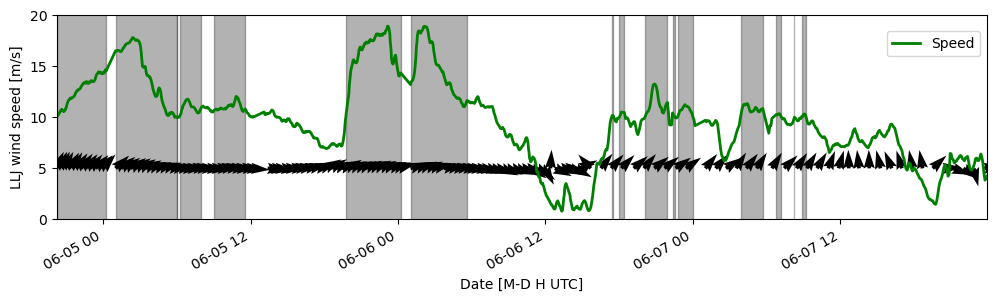

In [24]:
fig, ax = plt.subplots(figsize=(12, 3))
df = df.sort_index()
#df['value'][df['name'] == 'lidar.max_wind_direction'].plot(ax=ax, color='b', linewidth=2, label='Direction')
u = -np.sin(np.deg2rad(np.array(
    df['value'][df['name'] == 'lidar.max_wind_direction'].values, dtype='float')))
v = -np.cos(np.deg2rad(np.array(
    df['value'][df['name'] == 'lidar.max_wind_direction'].values, dtype='float')))
index = df['value'][df['name'] == 'lidar.max_wind_direction'].index
y = 5 * np.ones_like(index)
ax.quiver(index[::10], y[::10], u[::10], v[::10], scale=50)
df['value'][df['name'] == 'lidar.max_wind_speed'].plot(ax=ax, color='g', linewidth=2, label='Speed')
strategy = df['value'][df['name'] == 'lidar.strategy'] 

ax.set_xlabel('Date [M-D H UTC]')
ax.set_ylabel('LLJ wind speed [m/s]')

indicies = sorted(strategy.index.values)
ax.set_xlim([strategy.index.values[4], strategy.index.values.max()])
ax.fill_between(strategy.index.values, -30*np.ones_like(strategy.index.values, dtype='float32'),
                30*np.ones_like(strategy.index.values, dtype='float32'), strategy == 1, color='k', alpha=0.3)
ax.set_ylim([0, 20])
#ax.set_xticks(np.linspace(df.index.values[0], df.index.values[-1], 12))
fig.legend(bbox_to_anchor=(0.4, 0., 0.5, 0.85))
fig.savefig('timeseries.png', bbox_inches='tight')


In [49]:
df['value'][df['name'] == 'lidar.max_wind_direction'].values

array([216.09499285099645, 214.57457063501138, 213.79642197075728, ...,
       311.1051172195042, 307.6876114323414, 303.28289662466534],
      dtype=object)

In [5]:
vad = read_as_netcdf('/Users/rjackson/wfip3/data/VAD_184_20240601_011201.hpl', 0, 0, 0)
#dataset = read_as_netcdf(vad, 41.98053299237866, -87.71662374616044, 0.)
vad["signal_to_noise_ratio"] = vad["intensity"] - 1
vad = act.retrievals.compute_winds_from_ppi(vad)

In [29]:
vad["wind_speed"].plot(y="height")
plt.xlim([0, 17])
plt.ylim([0, 1000])

NameError: name 'vad' is not defined

(0.0, 1000.0)

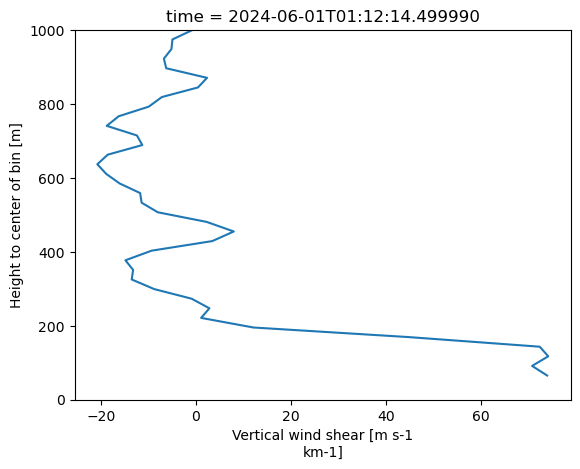

In [18]:
dz = vad.height.diff(dim='height').values[0] * 1e-3
vad["vert_shear"] = (['time', 'height'], np.gradient(vad["wind_speed"], dz, axis=1))
vad["vert_shear"].attrs["long_name"] = "Vertical wind shear"
vad["vert_shear"].attrs["units"] = "m s-1 km-1"
vad["vert_shear"].plot(y='height')
plt.ylim([0, 1000])

In [10]:
vad.height.diff(dim='height').values

array([25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98076211,
       25.98076211, 25.98076211, 25.98076211, 25.98076211, 25.98

In [102]:
stare = read_as_netcdf('/Users/rjackson/wfip3/data/Stare_184_20240601_01.hpl', 0, 0, 0)

Text(0, 0.5, 'Height [m]')

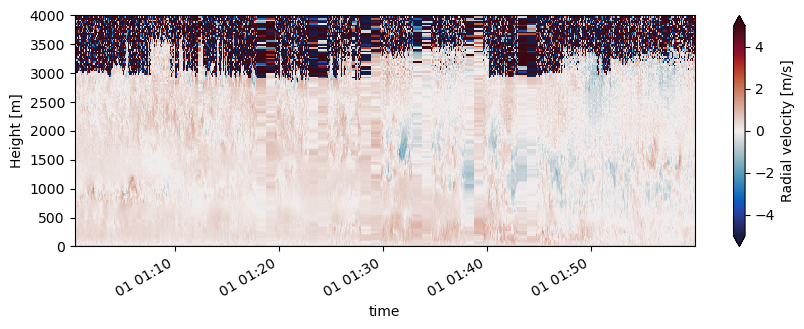

In [115]:
fig, ax = plt.subplots(figsize=(10, 3))
stare["radial_velocity"].T.plot(vmin=-5, vmax=5, cmap='balance', ax=ax,
                               cbar_kwargs=dict(label="Radial velocity [m/s]"))
ax.set_ylim([0, 4000])
ax.set_ylabel('Height [m]')